# Application de la VaR

Cheryl Kouadio  
2024-07-28

# Introduction

Nous allons ici nous intéresser aux applications de la Value at Risk
(VaR) en finance. La VaR est une mesure de risque qui permet d’estimer
les pertes maximales potentielles d’un portefeuille d’actifs financiers
sur un horizon de temps donné, à un certain niveau de confiance. Elle
est largement utilisée par les institutions financières pour évaluer et
gérer les risques de marché, de crédit et de liquidité (cf. [Value
at-Risk](3A/value-at-risk/var_def.qmd#sec-var-def)).

Nous verrons ainsi les applications des VaR analytique, historique et
Monte Carlo.

# Import des données

Nous utilisons les données du CAC 40 du 01/03/1990 au 10/05/2024. Le CAC
40 (Cotation Assistée en Continu) est l’indice boursier le plus
important de la Bourse de Paris. Son nom signifie que c’est un indice
composé des 40 sociétés françaises les plus significatives et les plus
liquides cotées sur Euronext Paris, qui est l’une des principales places
boursières en Europe.

In [2]:
# Librairie où importer les données
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
_ = yf.Ticker("^FCHI")
ts_data = _.history("max")
ts_data.index = ts_data.index.strftime('%Y-%m-%d')
ts_data.columns

/Users/cherylkouadio/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

La prix de la clôture, c’est à dire, le prix final de l’indice à la fin
de la session de trading sur Euronext Paris, est la bourse où l’indice
est coté. Celà reflète l’impact des nouvelles économiques, des
performances des entreprises comprises dans l’indice, et des mouvements
généraux du marché.

Nous l’utiliserons pour calculer le rendement (arithmétique) pour avoir
le pourcentage de changement de prix pour l’indice CAC40 qui définit
notre distribution de probabilité pour les gains ou les pertes
quotidiens.

Le rendement entre $t$ et $t-1$ se calcule comme suit :

$$
R_{t} = \frac{P_{t}-P_{t-1}}{P_{t-1}}
$$

où $P_{t}$ est le prix de clôture à la date $t$.

In [3]:
import warnings
warnings.filterwarnings('ignore')
ts_data = ts_data[[ 'Close']]
import pandas as pd
import numpy as np


ts_data['Return'] = ts_data["Close"].pct_change()
ts_data = ts_data.dropna(subset=['Return'])
print(ts_data.head())

             Close    Return
Date                        
1990-03-02  1860.0  0.015284
1990-03-05  1874.0  0.007527
1990-03-06  1872.0 -0.001067
1990-03-07  1880.0  0.004274
1990-03-08  1917.0  0.019681

# Test de stationarité du log-rendement

Pour utiliser le rendement comme variable profit et perte (PnL : Profit
and Loss) pour impléter la VaR, nous devons tester sa stationarité. En
effet, la stationarité est une propriété importante des séries
temporelles financières. Une série temporelle est dite stationnaire si
ses propriétés statistiques telles que la moyenne, la variance et la
covariance restent constantes au fil du temps.

<Figure size 576x384 with 0 Axes>

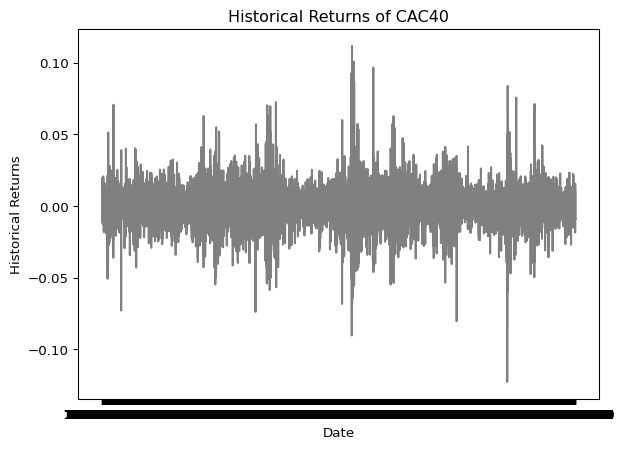

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

fig, ax = plt.subplots(1)

ax.set_xlabel('Date')
ax.set_ylabel('Historical Returns')
ax.plot(ts_data.index, ts_data['Return'], color='grey')
ax.tick_params(axis='y')

plt.title('Historical Returns of CAC40')
plt.show()

Il semblerait que la série des rendements est stationnaire. Nous allons
tout de même en observant l’ACF et le PACF mais aussi effectuer un test
de stationarité pour confirmer cette hypothèse.

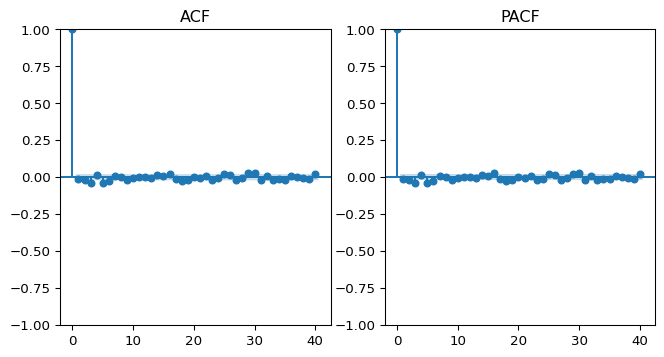

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plot_acf(ts_data['Return'].dropna(), ax=ax[0],title='ACF')
plot_pacf(ts_data['Return'].dropna(), ax=ax[1],title='PACF')
plt.show()

L’autocorrélation(ACF) et l’autocorrélation partielle(PACF) décroissent
de manière exponentielle, ce qui indique que la série est stationnaire.

Pour plus de certitude, nous allons effectuer un test de Dickey-Fuller
augmenté (ADF) pour tester la stationnaire dans la série :

$$ 
H_0=\rho = 1, \alpha=0
$$

Dans le cas d’une série AR(1)($X_t = \alpha + \rho X_{t-1} + \xi_t$)
avec intercept, la série est non stationnaire si $\rho = 1$ et
stationnaire si \$\< 1. Dans le cas contraire, il faudrait considérer la
série de différences pour la rendre stationnaire.

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(ts_data['Return'].dropna(), regression='c')
print(f"ADF Statistic: {round(adf_result[0],2)} and p-value: {adf_result[1]}")

ADF Statistic: -41.49 and p-value: 0.0

La p-value du test de dickey fuller est environ égale à 0, ce qui
signifie que nous rejetons l’hypothèse nulle selon laquelle la série
n’est pas stationnaire. Ainsi la série des log-rendements est
stationnaire. Nous pouvons donc utiliser les rendements logarithmiques
pour calculer la VaR à horizon 1 jour.

# Modélisation de la VaR

Pour modéliser la VaR, nous considérons un échantillon d’apprentissage
avec 75% (6513) des données et 25% (2172) pour l’échantillon de test.

In [7]:
train_size = int(len(ts_data)*0.75)
test_size = len(ts_data)-train_size

train_close = ts_data.iloc[0:train_size,:].dropna()
test_close = ts_data.iloc[train_size:len(ts_data),:]
print("Taille de l'ensemble d'apprentissage :", len(train_close))
print("Taille de l'ensemble de test :", len(test_close))

Taille de l'ensemble d'apprentissage : 6669
Taille de l'ensemble de test : 2224

## VaR analytique

Pour rappel, la VaR analytique ou gaussienne est basée sur la
distribution gaussienne des rendements. Nous allons utiliser la
distribution normale pour calculer la VaR à horizon 1 jour. La VaR à
horizon 1 jour est définie comme suit :

$$
VaR = -\mu_{PnL} + \Phi^{-1}(\alpha) \times \sigma_{PnL}
$$ où $\Phi^{-1}(\alpha)$ est le quantile de la distribution normale du
PnL (Profit and Loss) à $\alpha$.

Pour ce faire, nous allons tester que les rendements suivent une loi
normale. Nous utiliserons le test de Shapiro (`shapiro` dans la
librairie `scipy.stats`) dont l’hypothèse nulle est que la population
étudiée suit une distribution normale.

In [8]:
from scipy import stats
stats.shapiro(train_close["Return"]).pvalue

np.float64(5.234784789977662e-41)

Nous obtenons une pvaleur quasiment nulle donc nous rejettons
l’hypothèse de la distribution normale de nos rendements. Celà est plus
visible avec le QQ-plot ci dessous qui montre clairement que les queues
de distribution du rendement ne suit pas une loi normale.

Text(0.5, 1.0, 'QQ-plot')

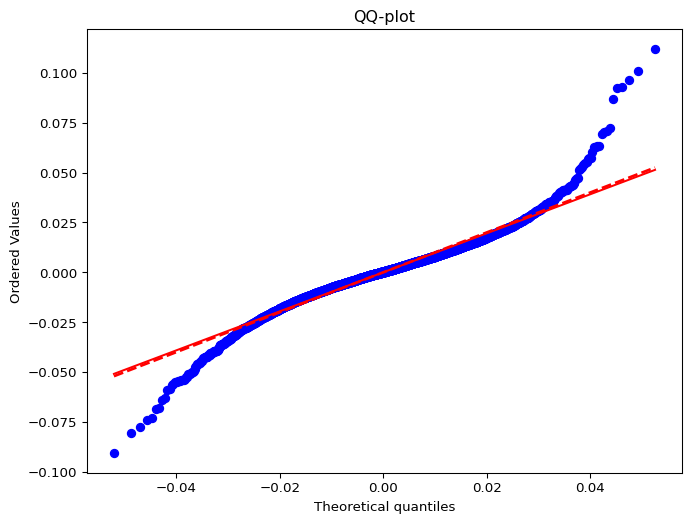

In [9]:
## Analyse graphique avec le QQ-plot
plt.figure(figsize=(8, 6))
probplot = stats.probplot(train_close["Return"], 
                        sparams = (np.mean(train_close["Return"]), np.std(train_close["Return"])), 
                        dist='norm', plot=plt)
plt.plot(probplot[0][0], probplot[0][0], color='red', linestyle='dashed', linewidth=2, label='Première bissectrice')
plt.title('QQ-plot')

In [10]:
from scipy import stats
def gaussian_var(PnL, seuil):
    mean_PnL = np.mean(PnL)
    sd_PnL = np.std(PnL)
    VaR = - mean_PnL + sd_PnL * stats.norm.ppf(seuil)
    return VaR

seuil = 0.99
VaR_gaussienne = gaussian_var(train_close["Return"], seuil)

print(f"La VaR à horizon 1 jour est de {round(VaR_gaussienne, 4)}")

La VaR à horizon 1 jour est de 0.0326

La VaR à horizon 1 jour est de 0.0324, ce qui signifie que la perte
maximale en terme de rendements du portefeuille est de 3.24% en un jour.

Sur 10 jours, la VaR est de $VaR_{1j} \times \sqrt{10}=$ 10.24%. Pour le
visualiser sur la distribution des rendements, nous avons le graphique
ci-dessous :

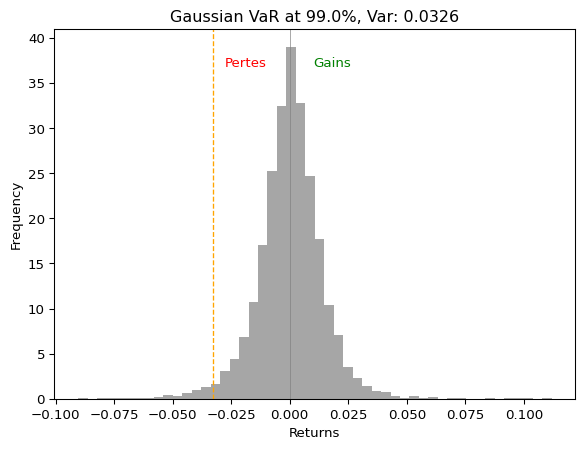

In [11]:
# Plot histogram of returns
plt.hist(train_close["Return"], bins=50, density=True, alpha=0.7,color="grey")

# Plot VaR line
plt.axvline(x=-VaR_gaussienne, color="orange", linestyle="--", linewidth=1)
plt.axvline(x=0, color="grey",  linewidth=0.5)

# Add text for Loss and Gain
plt.text(-0.01, plt.ylim()[1] * 0.9, 'Pertes', horizontalalignment='right', color='red')
plt.text(0.01, plt.ylim()[1] * 0.9, 'Gains', horizontalalignment='left', color='green')


# Add labels and title
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title(f"Gaussian VaR at {seuil * 100}%, Var: {VaR_gaussienne:.4f}")

# Show the plot
plt.show()

### Backtesting

Pour backtester la VaR, nous allons comparer dans l’échantillon test les
rendements avec la VaR à horizon 1 jour. Si le rendement est inférieur à
l’opposé de la VaR gaussienne, alors la VaR est violée et celà
correspond à une exception.

Ci dessous, le graphique qui permet de visualiser le nombre d’exceptions
que nous comptabilisons sur nos données test.

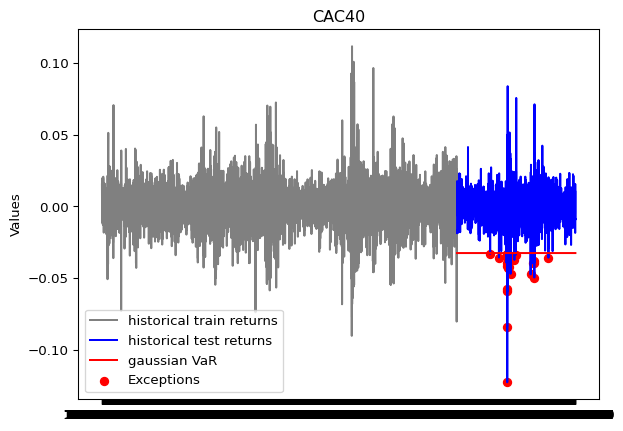

In [12]:
plt.plot(ts_data.index[0:train_size], train_close['Return'], label="historical train returns", color = 'gray')
plt.plot(ts_data.index[train_size:], test_close['Return'], label="historical test returns", color = 'blue')
plt.plot(ts_data.index[train_size:], [-VaR_gaussienne for i in range(test_size)], label="gaussian VaR", color = 'red')
list_exceptions_gaus = [i for i in range(len(test_close['Return'])) if test_close['Return'][i]<-VaR_gaussienne]
plt.scatter(test_close.index[list_exceptions_gaus], test_close['Return'][list_exceptions_gaus], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

Nous pouvons compter le nombre d’exceptions pour la VaR à horizon 1 jour
qui est égale à 30 et en déduisons que le taux d’exception est 1.38%.

In [13]:
round((len(list_exceptions_gaus)/test_size)*100,2) 

1.12

Pour tester la pertinence de la VaR calculée, il faudrait idéalement que
le taux d’exception soit inférieur à 1%. Pour ce faire, nous pouvons
effectuer un test de proportion. Nous utiliserons la fonction
`stats.binomtest` pour effectuer ce test.

In [14]:
def ptest(p0,n,k) :
  variance=p0*(1-p0)/n
  p=(k/n)
  t=(p-p0)/np.sqrt(variance)

  pvaleur=1-stats.norm.cdf(t)
  return pvaleur

ptest(0.01,test_size,len(list_exceptions_gaus))

np.float64(0.2781994499428806)

La pvaleur de ce test est 3.70%, celà est inférieur à 5% donc nous
rejetons l’hypothèse nulle selon laquelle le taux d’exception est égale
à 0.01 au risque 5% de se tromper. Celà nous indique que la VaR
gaussienne n’est pas performante. Ceci n’est pas surprenant étant donné
que nous faisons une hypothèse sur la distribution des rendements qui
n’est pas vérifiée.

## VaR historique

La VaR historique est basée sur les rendements historiques. Elle est
définie comme l’opposé du quantile de niveau $1-\alpha$ des rendements
historiques.

Considérons les mouvements de prix quotidiens pour l’indice CAC40 au
cours des 6513 jours de trading. Nous avons donc 6513 scénarios ou cas
qui serviront de guide pour les performances futures de l’indice,
c’est-à-dire que les 6513 derniers jours seront représentatifs de ce qui
se passera demain.

Ainsi donc la VaR historique pour un horizon de 1jour à 99% correspond
au 1er percentile de la distribution de probabilité des rendements
quotidiens (le top 1% des pires rendements).

In [15]:
def historical_var(PnL, seuil):
    return -np.percentile(PnL, (1 - seuil) * 100)

VaR_historique = historical_var(train_close["Return"],seuil)
print(f"La VaR historique à horizon 1 jour est de {round(VaR_historique, 4)}")

La VaR historique à horizon 1 jour est de 0.0396

Nous en déduisons que la perte maximale en terme de rendements du
portefeuille est de 3.96% en un jour (soit 12.52% en 10jours)

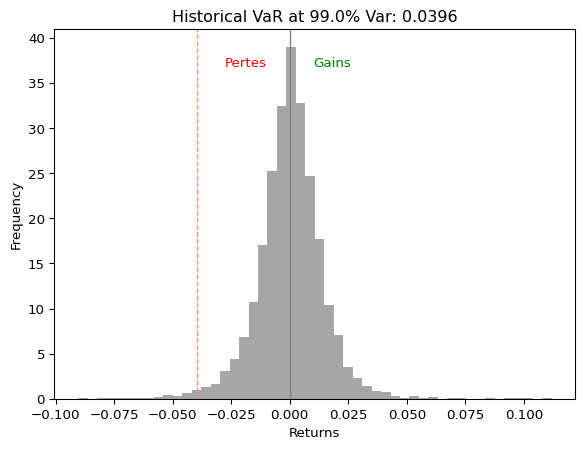

In [16]:
# Plot histogram of returns
plt.hist(train_close["Return"], bins=50, density=True, alpha=0.7,color="grey")

# Plot VaR line
plt.axvline(x=-VaR_historique, color="orange", linestyle="--", linewidth=1)
plt.axvline(x=0, color="grey",  linewidth=1)
# Add text for Loss and Gain
plt.text(- 0.01, plt.ylim()[1] * 0.9, 'Pertes', horizontalalignment='right', color='red')
plt.text(0.01, plt.ylim()[1] * 0.9, 'Gains', horizontalalignment='left', color='green')


# Add labels and title
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title(f"Historical VaR at {seuil * 100}% Var: {VaR_historique:.4f}")

# Show the plot
plt.show()

### Backtesting

En ce qui concerne le backtesting, nous pouvons voir que la VaR
historique est beaucoup moins violée dans l’échantillon test que la VaR
gaussienne. Le taux d’exception est de 0.64%.

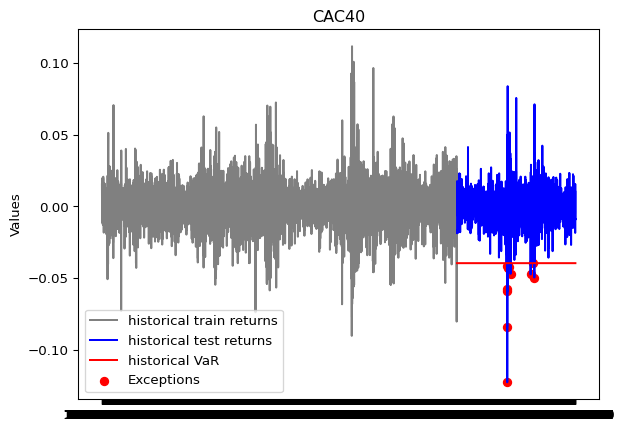

In [17]:
import matplotlib.pyplot as plt
plt.plot(ts_data.index[0:train_size], train_close['Return'], label="historical train returns", color = 'gray')
plt.plot(ts_data.index[train_size:], test_close['Return'], label="historical test returns", color = 'blue')
plt.plot(ts_data.index[train_size:], [-VaR_historique for i in range(test_size)], label="historical VaR", color = 'red')
list_exceptions_hist = [i for i in range(len(test_close['Return'])) if test_close['Return'][i]<-VaR_historique]
plt.scatter(test_close.index[list_exceptions_hist], test_close['Return'][list_exceptions_hist], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

Nous pouvons compter le nombre d’exceptions pour la VaR à horizon 1 jour
qui est égale à 14 et en déduisons que le taux d’exception est 0.64%. Ce
taux d’exception est statistiquement supérieur à 1% (car la pvaleur est
d’environ 0.95). Ainsi, la VaR historique est performante pour la
période considérée.

In [18]:
round((len(list_exceptions_hist)/test_size)*100,2) 
ptest(0.01,test_size,len(list_exceptions_hist))

np.float64(0.9854563959649583)

## VaR Monte Carlo

La VaR Monte Carlo est basée sur la simulation de trajectoires de
rendements. Nous allons simuler jusqu’à 10000 scénarios de rendements et
calculer la VaR à horizon 1 jour en posant une hypothèse de normalité
sur la distribution des rendements afin de voir quand est ce que la VaR
se stabilise.

In [19]:
VaR_results = []

num_simulations_list = range(10, 10000 + 1, 1)
mean=train_close["Return"].mean()
std = train_close["Return"].std()

for num_simulations in num_simulations_list:
  # Generate random scenarios of future returns
  simulated_returns = np.random.normal(mean, std, size= num_simulations)

  # Calculate portfolio values for each scenario
  portfolio_values = (train_close["Close"].iloc[-1] * (1 + simulated_returns))

  # Convert portfolio_values into a DataFrame
  portfolio_values = pd.DataFrame(portfolio_values)

  # Calculate portfolio returns for each scenario
  portfolio_returns = portfolio_values.pct_change()
  portfolio_returns=portfolio_returns.dropna()
  portfolio_returns=portfolio_returns.mean(axis=1)


  # Calculate VaR
  if portfolio_returns.iloc[-1] != 0:
      VaR_monte_carlo =  historical_var(portfolio_returns,seuil)
  else:
      VaR_monte_carlo = 0
  
  VaR_results.append(VaR_monte_carlo)

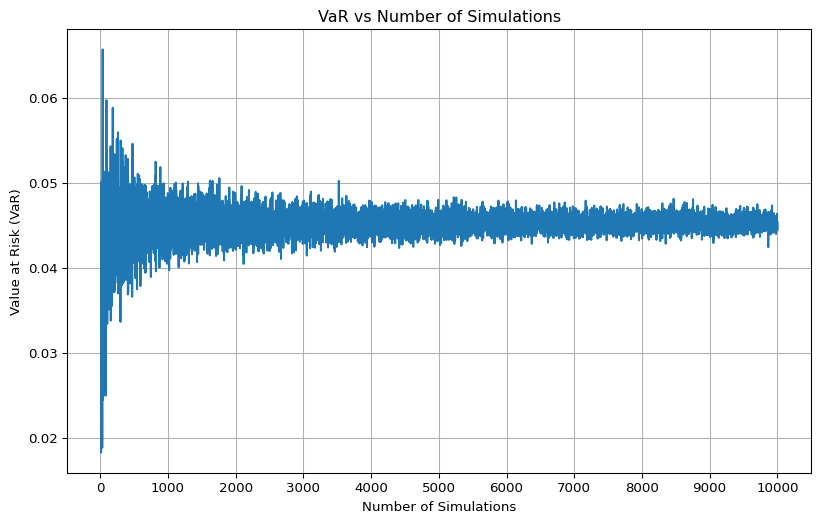

In [20]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.xticks(np.arange(0,10000 + 1, 1000))
plt.plot(num_simulations_list, VaR_results, linestyle='-')
plt.xlabel('Number of Simulations')
plt.ylabel('Value at Risk (VaR)')
plt.title('VaR vs Number of Simulations')
plt.grid(True)
plt.show()
# Customize x-axis ticks

Visuellement, la VaR se stabilise à partir de 3000 scénarios. Nous
utiliserons donc 3000 simulations de rendements. Nous en déduisons que
la perte maximale en terme de rendements du portefeuille est de 4.31% en
un jour (soit 13.98% en 10jours)

In [21]:
num_simulations = 3000

# Generate random scenarios of future returns
simulated_returns = np.random.normal(mean, std, size= num_simulations)

# Calculate portfolio values for each scenario
portfolio_values = (train_close["Close"].iloc[-1] * (1 + simulated_returns))

# Convert portfolio_values into a DataFrame
portfolio_values = pd.DataFrame(portfolio_values)

# Calculate portfolio returns for each scenario
portfolio_returns = portfolio_values.pct_change()
portfolio_returns=portfolio_returns.dropna()
portfolio_returns=portfolio_returns.mean(axis=1)


# Calculate VaR
if portfolio_returns.iloc[-1] != 0:
    VaR_monte_carlo =  historical_var(portfolio_returns,seuil)
else:
    VaR_monte_carlo = 0

VaR_monte_carlo

np.float64(0.045627238484798154)

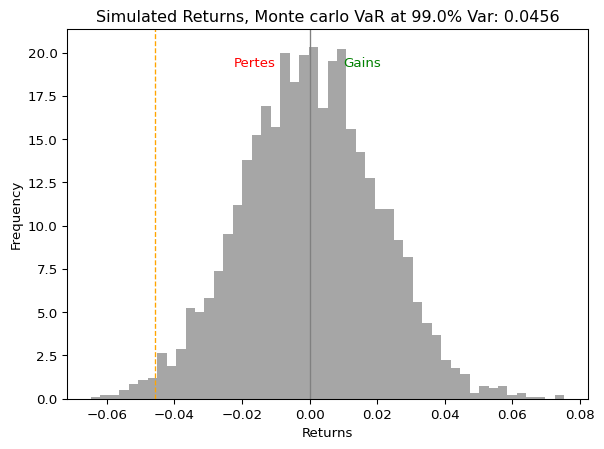

In [22]:
# Plot histogram of returns
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.7,color="grey")

# Plot VaR line
plt.axvline(x=-VaR_monte_carlo, color="orange", linestyle="--", linewidth=1)
plt.axvline(x=0, color="grey",  linewidth=1)
# Add text for Loss and Gain
plt.text(- 0.01, plt.ylim()[1] * 0.9, 'Pertes', horizontalalignment='right', color='red')
plt.text(0.01, plt.ylim()[1] * 0.9, 'Gains', horizontalalignment='left', color='green')


# Add labels and title
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.title(f"Simulated Returns, Monte carlo VaR at {seuil * 100}% Var: {VaR_monte_carlo:.4f}")

# Show the plot
plt.show()

### Backtesting

En ce qui concerne le backtesting, nous pouvons voir que la VaR
historique est beaucoup moins violée dans l’échantillon test que les
deux autres VaRs. En effet, le taux d’exception est de 0.37%.

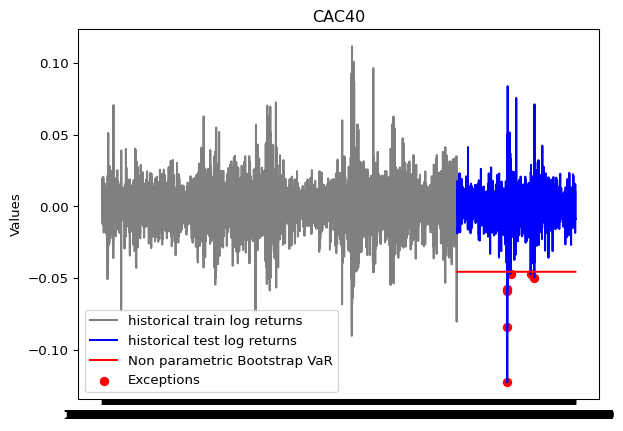

In [23]:
plt.plot(ts_data.index[0:train_size], train_close['Return'], label="historical train log returns", color = 'gray')
plt.plot(ts_data.index[train_size:], test_close['Return'], label="historical test log returns", color = 'blue')
plt.plot(ts_data.index[train_size:], [-VaR_monte_carlo for i in range(test_size)], label="Non parametric Bootstrap VaR", color = 'red')
list_exceptions_np_boot = [i for i in range(len(test_close['Return'])) if test_close['Return'][i]<-VaR_monte_carlo]
plt.scatter(test_close.index[list_exceptions_np_boot], test_close['Return'][list_exceptions_np_boot], color='red', label='Exceptions')
plt.title('CAC40')
plt.ylabel('Values')
plt.plot()
plt.legend()
plt.show()

Ce taux est statistiquement inférieur à 1% ce qui temoigne de la
performance de la VaR monte carlo.

In [24]:
round((len(list_exceptions_np_boot)/test_size)*100,2) 
ptest(0.01,test_size,len(list_exceptions_np_boot))

np.float64(0.999418658576952)

# Comparaison des VaRs

Comme on peut le constater, les différentes méthodes d’implémentations
de VaR donnent des résultats différents. Toutefois, la VaR la plus
performante est la VaR monte carlo en faisant l’hypothèse de
distribution normale des rendements.

In [25]:
# Print the VaR values
print(f"Parametric VaR: {VaR_gaussienne:.2%}, Pvalue du backtesting: {ptest(0.01, test_size, len(list_exceptions_gaus)):.4f}")
print(f"Historical VaR: {VaR_historique:.2%}, Pvalue du backtesting: {ptest(0.01, test_size, len(list_exceptions_hist)):.4f}")
print(f"Monte Carlo VaR: {VaR_monte_carlo:.2%}, Pvalue du backtesting: {ptest(0.01, test_size, len(list_exceptions_np_boot)):.4f}")

Parametric VaR: 3.26%, Pvalue du backtesting: 0.2782
Historical VaR: 3.96%, Pvalue du backtesting: 0.9855
Monte Carlo VaR: 4.56%, Pvalue du backtesting: 0.9994